[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MeyerBender/spatialproteomics_workshop/blob/main/notebooks/workshop01_solution.ipynb)

# Analysis of highly multiplexed fluorescence images with spatialproteomics
Welcome to spatialproteomics! In this notebook, we will go through an example workflow by looking at the following steps:
1. Reading in a highly multiplexed image and creating a spatialproteomics object
2. Performing basic image processing to boost the signal-to-noise ratio
3. Performing nuclear segmentation using _cellpose_
4. Quantifying protein expression per cell
5. Predicting cell types with a simple argmax technique
6. Plotting the results

In [1]:
# download the data
# if you have already run this cell once, there is no need to run it again

# use this when running on colab
! wget https://www.huber.embl.de/users/matthias/spatialproteomics_workshop_data.tar.gz /content/spatialproteomics_workshop_data.tar.gz
! tar -xzf /content/spatialproteomics_workshop_data.tar.gz
! pip install --quiet spatialproteomics[cellpose]==0.7
data_dir = '/content/data'

# use this when running locally
# ! wget https://www.huber.embl.de/users/matthias/spatialproteomics_workshop_data.tar.gz spatialproteomics_workshop_data.tar.gz
# ! tar -xzf spatialproteomics_workshop_data.tar.gz
# data_dir = 'data'

--2024-11-26 09:47:31--  https://www.huber.embl.de/users/matthias/spatialproteomics_workshop_data.tar.gz
Resolving www.huber.embl.de (www.huber.embl.de)... 192.168.210.19
Connecting to www.huber.embl.de (www.huber.embl.de)|192.168.210.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210111568 (200M) [application/gzip]
Saving to: ‘spatialproteomics_workshop_data.tar.gz.3’

spatialproteomics_w 100%[===================>] 200.38M   110MB/s    in 1.8s    

2024-11-26 09:47:33 (110 MB/s) - ‘spatialproteomics_workshop_data.tar.gz.3’ saved [210111568/210111568]

--2024-11-26 09:47:33--  http://spatialproteomics_workshop_data.tar.gz/
Resolving spatialproteomics_workshop_data.tar.gz (spatialproteomics_workshop_data.tar.gz)... failed: nodename nor servname provided, or not known.
wget: unable to resolve host address ‘spatialproteomics_workshop_data.tar.gz’
FINISHED --2024-11-26 09:47:33--
Total wall clock time: 1.9s
Downloaded: 1 files, 200M in 1.8s (110 MB/s)


In [2]:
import spatialproteomics as sp
from skimage.io import imread
import matplotlib.pyplot as plt
from scipy.signal import medfilt2d
import os

## 1. Getting Started

Before we can get started with _spatialproteomics_, we first need to read in the image. Highly multiplexed fluorescence images are typically stored in the _tiff_ file format, which can be read in via the _skimage_ or _tifffile_ libraries. In addition, it is common practice to store the list of markers used during imaging in a txt file. Here, we read in the image and the marker list and combine the two into a _spatialproteomics_ object.

Experimental background: this image is a tissue microarray (TMA) of a healthy lymph node.

In [3]:
# reading in the image and displaying its shape
image = imread(os.path.join(data_dir, 'lymph_node.tiff'))
image.shape

(56, 3000, 3000)

We can see that our image has 56 channels and has a size of 3,000 by 3,000 pixels. However, at this point we do not know, which channel corresponds to which marker. For this, we also need to read in the marker list.

In [4]:
# opening the file and read it line by line into a list
with open(os.path.join(data_dir, 'marker_list.txt'), 'r') as file:
    lines = file.readlines()

# removing any trailing newline characters from each line
markers = [line.strip() for line in lines]
len(markers)

56

Great! Now we can put the image and the marker names into a _spatialproteomics_ object.

In [5]:
sp_object = sp.load_image_data(image, channel_coords=markers)

`sp.load_image_data` returns an xarray object that we can simply inspect by calling in an jupyter cell. Note that the image is stored as the data variable `_image`.

In [6]:
sp_object

<xarray.Dataset>
Dimensions:   (channels: 56, y: 3000, x: 3000)
Coordinates:
  * channels  (channels) <U11 'DAPI' 'Helios' 'CD10' ... 'CD79a' 'Ki-67'
  * y         (y) int64 0 1 2 3 4 5 6 7 ... 2993 2994 2995 2996 2997 2998 2999
  * x         (x) int64 0 1 2 3 4 5 6 7 ... 2993 2994 2995 2996 2997 2998 2999
Data variables:
    _image    (channels, y, x) uint8 4 5 5 5 5 5 5 5 5 5 ... 2 2 2 1 2 2 2 2 2 1

Let's quickly look at what this image looks like. Since it is very difficult to perceive 56 different colors overlaid on top of one another, let's subset our dataset to 5 channels and see what they look like.

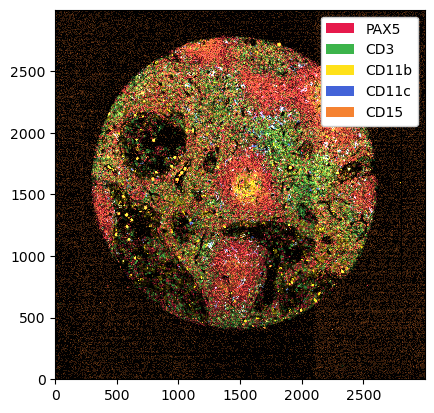

In [7]:
# pp = the preprocessing accessor
# pl = the plotting accessor

# subsetting the object
sp_object_subset = sp_object.pp[['PAX5', 'CD3', 'CD11b', 'CD11c', 'CD15']]

# plotting the result
_ = sp_object_subset.pl.show()

In [8]:
# Try looking at some different markers!
# Do you spot any interesting patterns? 
# Are all markers equally specific?

## 2. Image Processing
Highly multiplexed fluorescence imaging techniques frequently suffer from poor signal-to-noise ratio. To alleviate this problem, you can threshold out low intensity pixels, thereby boosting the contrast of the image. While there are automated methods to determine the thresholds for such operations, it is difficult to come up with one that works in all cases. Here, we therefore set the thresholds based on manual inspection.

Let's start by looking at the data set in the current form, limiting ourselves to a single channel for now. We can use `pl.autocrop()` and `pl.colorize()` to customize how our image is displayed.

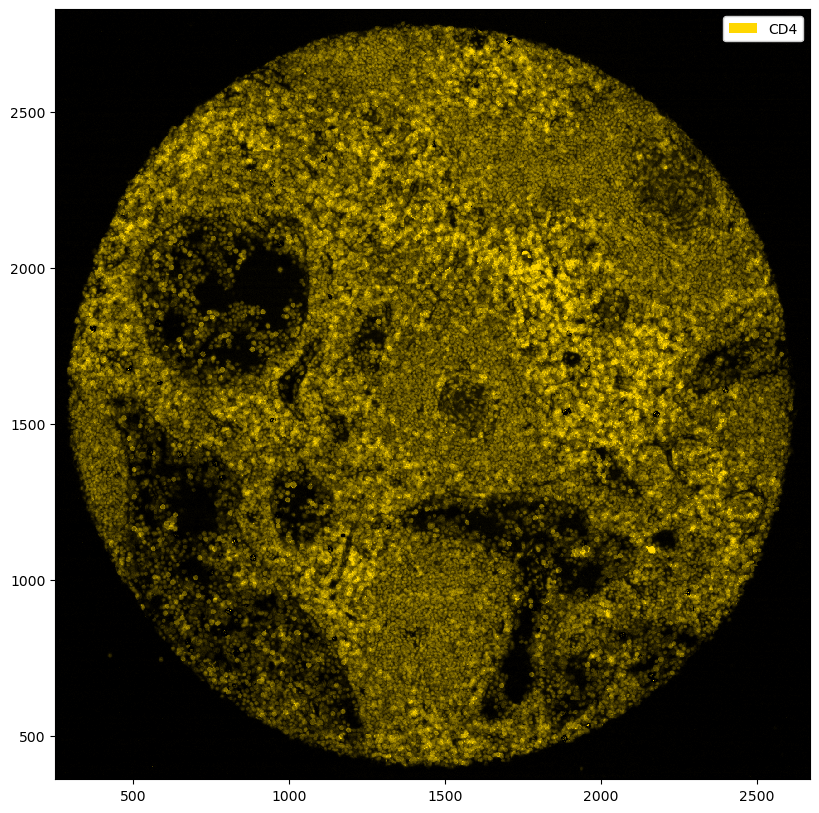

In [9]:
plt.figure(figsize=(10, 10))
_ = sp_object.pp['CD4'].pl.autocrop().pl.colorize('gold').pl.show()

It looks like CD4 bound to a lot of cells, however there are still some differences in intensities between cells. How do we know that not all of these cells should actually express CD4? CD4 is a marker for T helper cells, and should hence only be expressed on CD3+ T cells. If we look at the combination of CD3 and CD4, we can clearly see that CD4 is not specific to CD3+ cells.

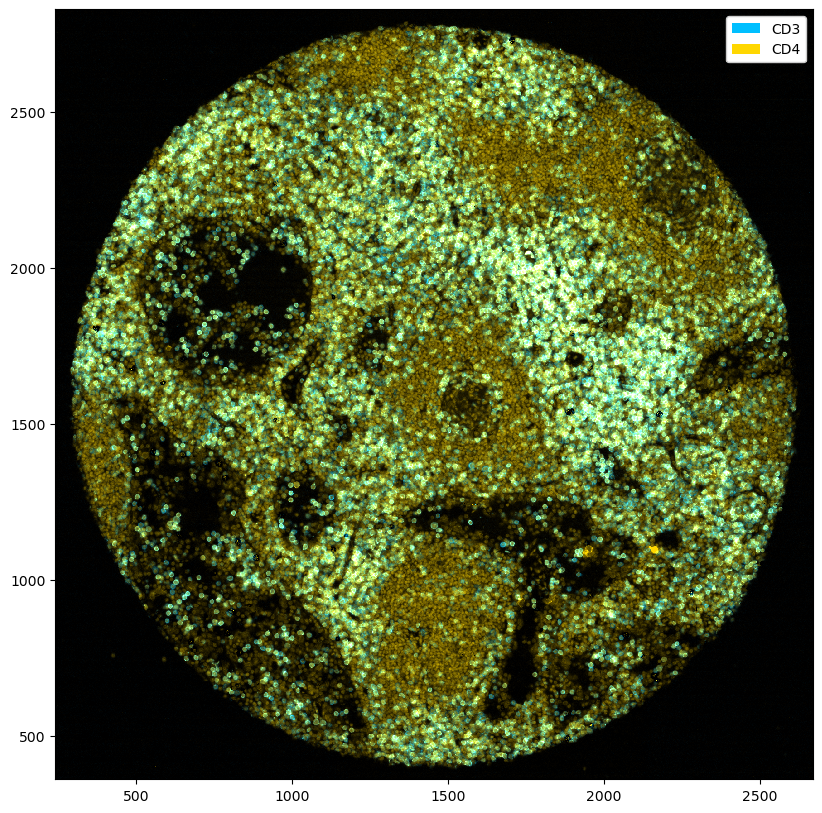

In [10]:
plt.figure(figsize=(10, 10))
_ = sp_object.pp[['CD3', 'CD4']].pl.colorize(['deepskyblue', 'gold']).pl.autocrop().pl.show()

What can we do against this? One option is to apply thresholding, which means that we set every pixel below a certain intensity to 0. Let's do this using the `pp.threshold()` method.

Text(0.5, 1.0, 'CD4 thresholded')

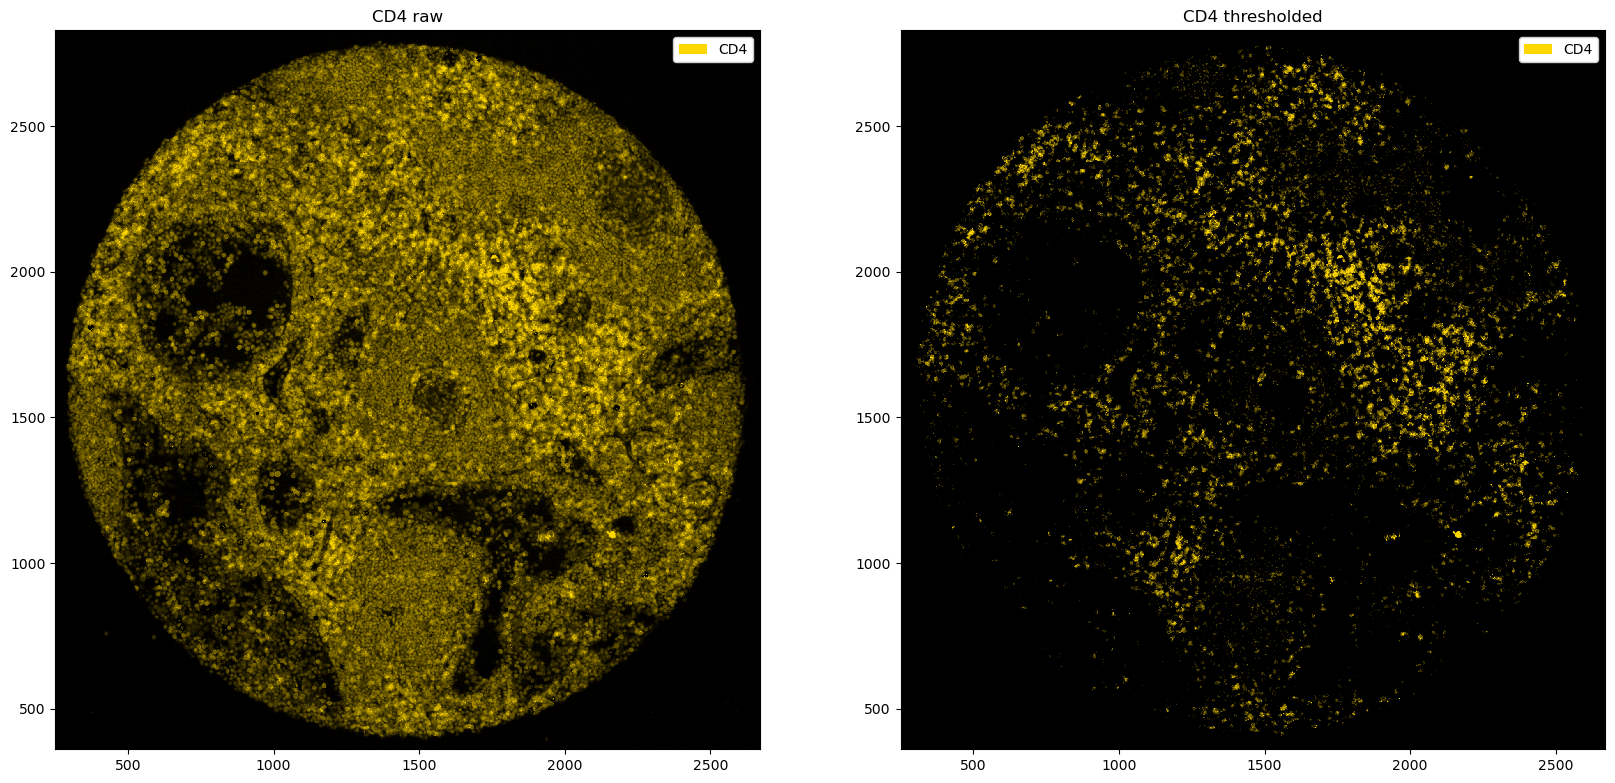

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
_ = sp_object.pp['CD4'].pl.autocrop().pl.colorize('gold').pl.show(ax=ax[0])
_ = sp_object.pp['CD4'].pp.threshold(quantile=0.9).pl.autocrop().pl.colorize('gold').pl.show(ax=ax[1])
ax[0].set_title('CD4 raw')
ax[1].set_title('CD4 thresholded')

In [12]:
# Try different thresholds! What do you observe? Can you come up with a reasonable threshold?

Let's look at a couple of markers which we can use to predict cell types. We will look for reasonable thresholds for all of them, and then see how the thresholding affected the resulting image.

In [13]:
channels = ['PAX5', 'CD3', 'CD11b', 'CD11c', 'CD15', 'CD68', 'Podoplanin', 'CD31', 'CD34', 'CD90', 'CD56']
quantiles = [0.8, 0.5, 0.8, 0.8, 0.8, 0.8, 0.95, 0.95, 0.95, 0.95, 0.8]
colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#ffd8b1', '#f58231', '#911eb4', '#fffac8', '#469990', '#fabed4', '#9A6324']

sp_object_thresholded = sp_object.pp[channels].pp.threshold(quantiles)

Text(0.5, 1.0, 'Thresholded')

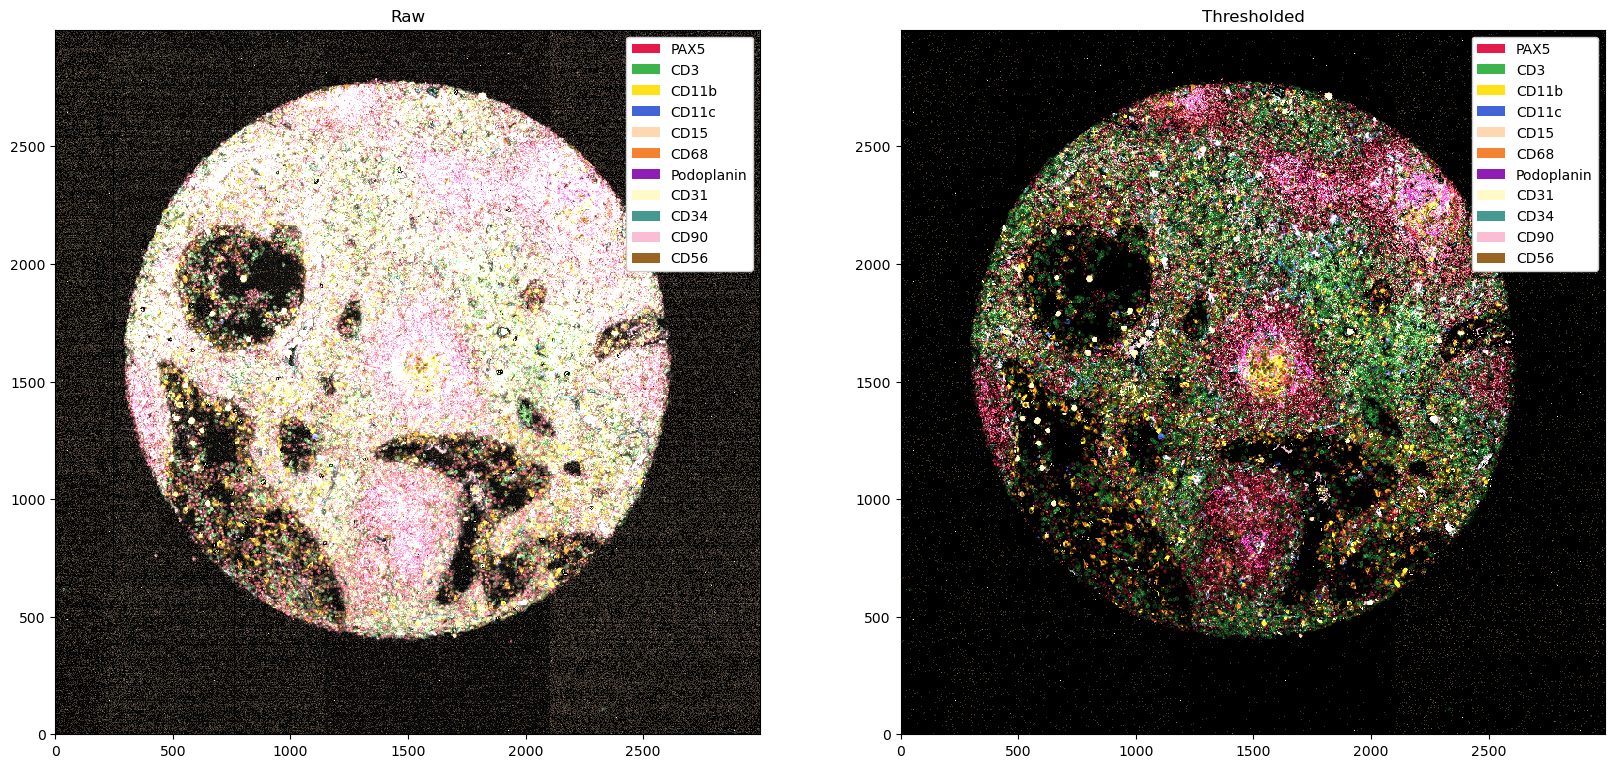

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# note that we use downsampling here, since colab only provides a limited amount of RAM
# if you have sufficient RAM available, you can remove the downsample step here
_ = sp_object.pp[channels].pp.downsample(4).pl.colorize(colors).pl.show(ax=ax[0])
_ = sp_object_thresholded.pp.downsample(4).pl.colorize(colors).pl.show(ax=ax[1])
ax[0].set_title('Raw')
ax[1].set_title('Thresholded')

Immediately, we can see the structures within the tissue much clearer. So now we have a much less noisy picture, but how can we get from this to a single-cell expression matrix?

## 3. Cell Segmentation

At this point, the only thing missing is a cell segmentation. Since we only have a nuclear marker at hand (and no membrane marker that would stain all cells), we will segment the nuclei and then simply extend the segmentation masks by two pixels in every direction. We are going to use _cellpose_ for this purpose, which is implemented in the tool (tl) module.

In [15]:
sp_object = sp_object.tl.cellpose(channel='DAPI')

TORCH CUDA version not installed/working.
>>>> using CPU
>> cyto3 << model set to be used
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
>>>> loading model /Users/mbender/.cellpose/models/cyto3
/Users/mbender/mambaforge/envs/eccb_env/lib/python3.11/site-packages/cellpose/resnet_torch.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start se

In [16]:
# extracting the segmentation and storing it as tiff file
import tifffile
segmentation = sp_object['_cellpose_segmentation'].values
tifffile.imwrite('segmentation.tiff', segmentation)

In [17]:
# reading the segmentation back in
segmentation = tifffile.imread('segmentation.tiff')

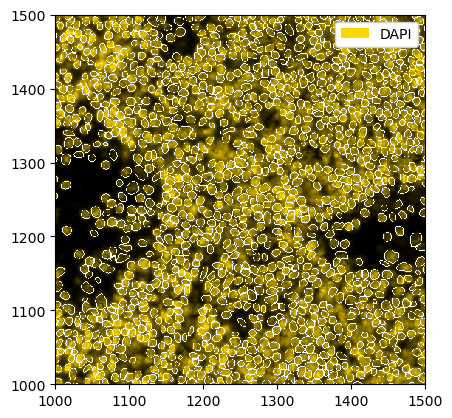

In [18]:
# this is how you could then add it to the object and visualize the result
# note that we do not overwrite sp_object here, however you should do this if you decide not to run cellpose yourself
_ = sp_object.pp.add_segmentation(segmentation).pp['DAPI', 1000:1500, 1000:1500].pl.colorize('gold').pl.show(render_segmentation=True)

Looking at the object, you will realize that a new layer called `_segmentation` has appeared. We can use this for downstream analysis and visualization.

In [19]:
sp_object = sp_object.pp.add_segmentation('_cellpose_segmentation')
sp_object

<xarray.Dataset>
Dimensions:                 (channels: 56, y: 3000, x: 3000, cells: 20291,
                             features: 2)
Coordinates:
  * channels                (channels) <U11 'DAPI' 'Helios' ... 'CD79a' 'Ki-67'
  * y                       (y) int64 0 1 2 3 4 5 ... 2995 2996 2997 2998 2999
  * x                       (x) int64 0 1 2 3 4 5 ... 2995 2996 2997 2998 2999
  * cells                   (cells) int64 1 2 3 4 5 ... 20288 20289 20290 20291
  * features                (features) <U10 'centroid-0' 'centroid-1'
Data variables:
    _image                  (channels, y, x) uint8 4 5 5 5 5 5 5 ... 2 2 2 2 2 1
    _cellpose_segmentation  (y, x) uint16 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    _segmentation           (y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    _obs                    (cells, features) float64 107.9 ... 1.362e+03

We can plot this segmentation over the DAPI channel to see what exactly _cellpose_ did. We can zoom in a little bit to get a clearer picture.

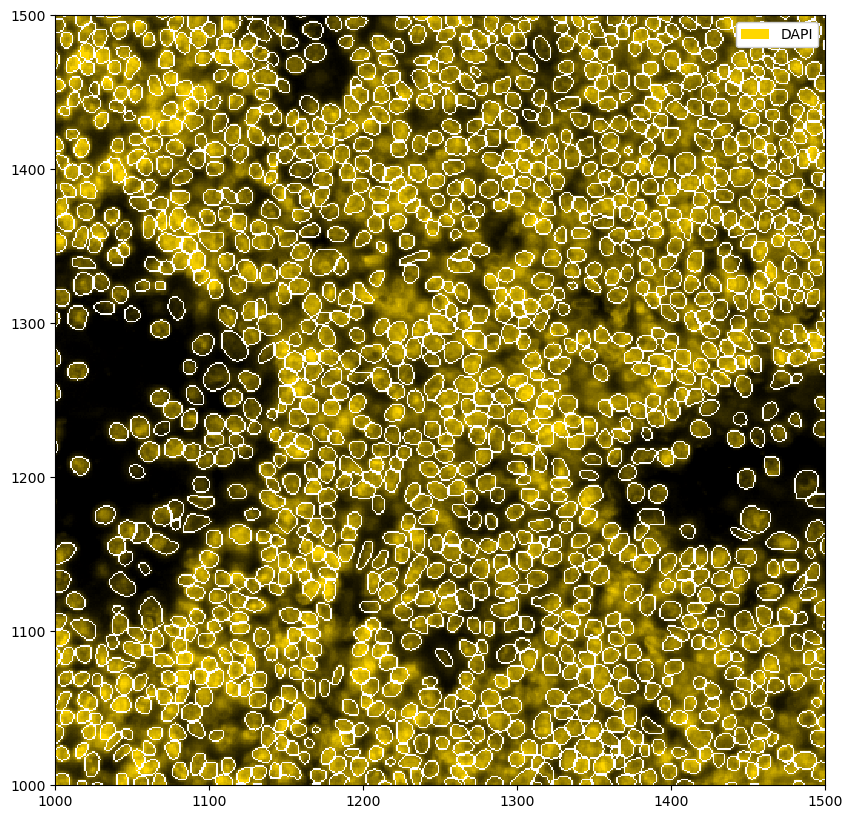

In [20]:
plt.figure(figsize=(10, 10))
_ = sp_object.pp['DAPI', 1000:1500, 1000:1500].pl.colorize('gold').pl.show(render_segmentation=True)

There are two issues with the current masks. One is that sometimes very small cells get segmented, which are likely artifacts. We can hence filter cells that are too small or too big. In addition, we will grow the masks by two pixels in each direction to try to capture cytoplasm and membrane.

Found _obs in image container. Concatenating.


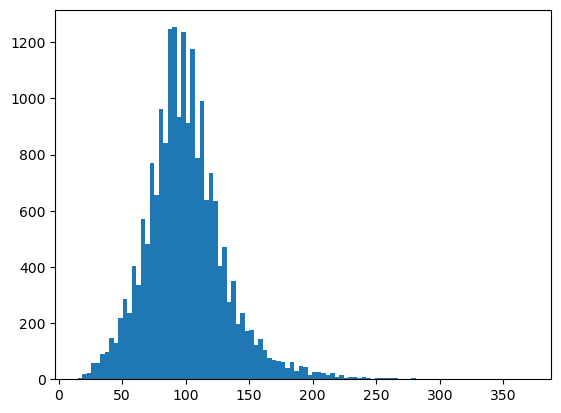

In [21]:
# checking the distribution of cell sizes
sp_object = sp_object.pp.add_observations("area")
df = sp_object.pp.get_layer_as_df('_obs')
_ = plt.hist(df['area'], bins=100)

In [22]:
# filtering out cells with less than 50 or more than 300 pixels
sp_object = sp_object.pp.filter_by_obs('area', func=lambda x: (x > 50) & (x < 300))

In [23]:
# expanding the masks
sp_object = sp_object.pp.grow_cells(iterations=2)

Mask growing requires recalculation of the observations. All features other than the centroids will be removed and should be recalculated with pp.add_observations().


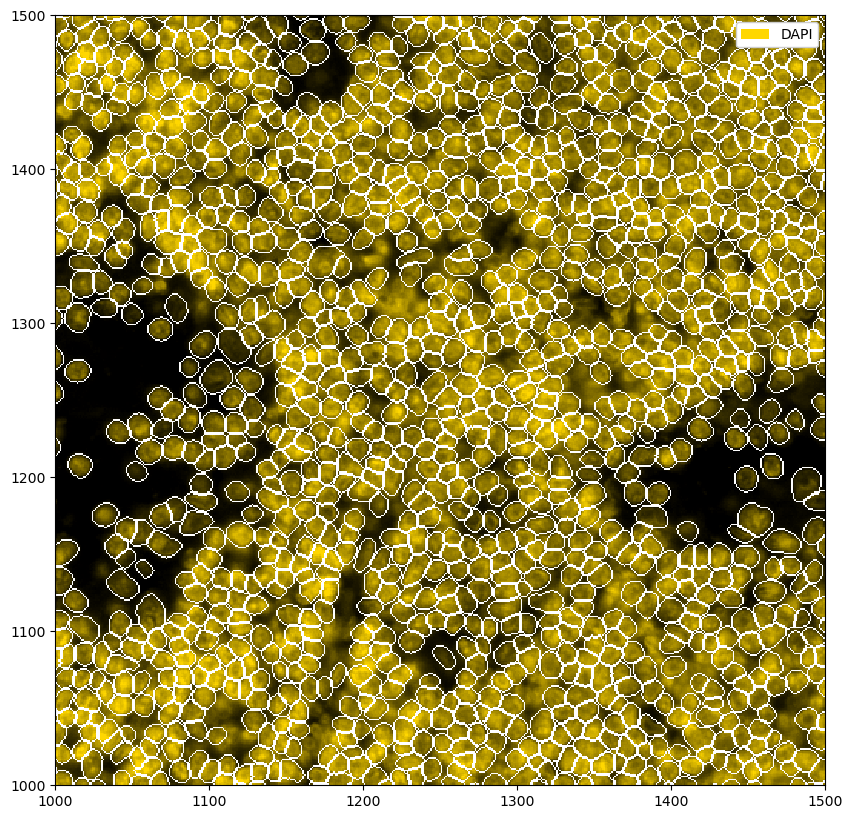

In [24]:
# plotting the result
plt.figure(figsize=(10, 10))
_ = sp_object.pp['DAPI', 1000:1500, 1000:1500].pl.colorize('gold').pl.show(render_segmentation=True)

## 4. Quantifying Protein Expression per Cell
Now that we have sensible segmentation masks, we can quantify the protein expression in each cell. There are multiple ways to do this, but taking the median intensity and then applying an arcsinh-transform has been proven to work pretty well.

In [25]:
# note that at this point, we have the segmentation in sp_object, but not in sp_object_thresholded
# we want to add the segmentation to the thresholded object
segmentation = sp_object['_segmentation'].values
sp_object_thresholded = sp_object_thresholded.pp.add_segmentation(segmentation)
sp_object_thresholded

<xarray.Dataset>
Dimensions:        (channels: 11, y: 3000, x: 3000, cells: 19449, features: 2)
Coordinates:
  * channels       (channels) <U11 'PAX5' 'CD3' 'CD11b' ... 'CD34' 'CD90' 'CD56'
  * y              (y) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
  * x              (x) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
  * cells          (cells) int64 1 2 3 4 5 6 ... 19445 19446 19447 19448 19449
  * features       (features) <U10 'centroid-0' 'centroid-1'
Data variables:
    _image         (channels, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    _segmentation  (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    _obs           (cells, features) float64 108.0 2.328e+03 ... 1.362e+03

In [26]:
sp_object_thresholded = sp_object_thresholded.pp.add_quantification(func='intensity_mean').pp.transform_expression_matrix(method='arcsinh')
sp_object_thresholded

<xarray.Dataset>
Dimensions:        (channels: 11, y: 3000, x: 3000, cells: 19449, features: 2)
Coordinates:
  * channels       (channels) <U11 'PAX5' 'CD3' 'CD11b' ... 'CD34' 'CD90' 'CD56'
  * y              (y) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
  * x              (x) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
  * cells          (cells) int64 1 2 3 4 5 6 ... 19445 19446 19447 19448 19449
  * features       (features) <U10 'centroid-0' 'centroid-1'
Data variables:
    _image         (channels, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    _segmentation  (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    _obs           (cells, features) float64 108.0 2.328e+03 ... 1.362e+03
    _intensity     (cells, channels) float64 0.0 1.602 ... 0.008791 0.07685

As you can see, this introduced a new layer called `_intensity`. We can now use this to predict cell types.

## 5. Cell Type Prediction
There are several ways to predict cell types. Since we thresholded our data beforehand, we can simply take the argmax of the cell type specific channels to get an idea of the cell types we are looking at. Methods related to cell type prediction are all implemented in the label (la) module.

In [27]:
# this dictionary maps from cell types to markers
ct_marker_dict = {'B': 'PAX5', 'T': 'CD3', 'Myeloid': 'CD11b', 'Dendritic': 'CD11c', 'Granulo': 'CD15', 'Macro': 'CD68', 'Stroma PDPN': 'Podoplanin', 'Stroma CD31': 'CD31', 'Stroma CD34': 'CD34', 'Stroma CD90': 'CD90', 'NK': 'CD56'}
sp_object_thresholded = sp_object_thresholded.la.predict_cell_types_argmax(ct_marker_dict)

In [28]:
sp_object_thresholded

<xarray.Dataset>
Dimensions:         (labels: 11, la_props: 2, channels: 11, y: 3000, x: 3000,
                     cells: 19449, features: 3)
Coordinates:
  * labels          (labels) int64 1 2 3 4 5 6 7 8 9 10 11
  * la_props        (la_props) <U6 '_color' '_name'
  * channels        (channels) <U11 'PAX5' 'CD3' 'CD11b' ... 'CD90' 'CD56'
  * y               (y) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
  * x               (x) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
  * cells           (cells) int64 1 2 3 4 5 6 ... 19445 19446 19447 19448 19449
  * features        (features) <U10 '_labels' 'centroid-0' 'centroid-1'
Data variables:
    _la_properties  (labels, la_props) object '#FAD09F' 'B' ... '#A77500' 'T'
    _image          (channels, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    _segmentation   (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    _obs            (cells, features) float64 11.0 108.0 ... 2.785e+03 1.362e+03
    _intensity      (cells, channels) float64 0.0 1.602 ... 0.008791 0.07685

This added a couple of things. For one, `_obs` now contains a feature called `_labels`. Furthermore, the `_la_properties` layer assigns each cell type to a color, which can be useful for plotting.

## 6. Plotting
Finally, let's do some plotting of the predicted cell types next to the markers. Before plotting, we can set some colors for the cell types (labels).

In [29]:
# setting the colors for the cell types
sp_object_thresholded = sp_object_thresholded.la.set_label_colors(ct_marker_dict.keys(), colors)

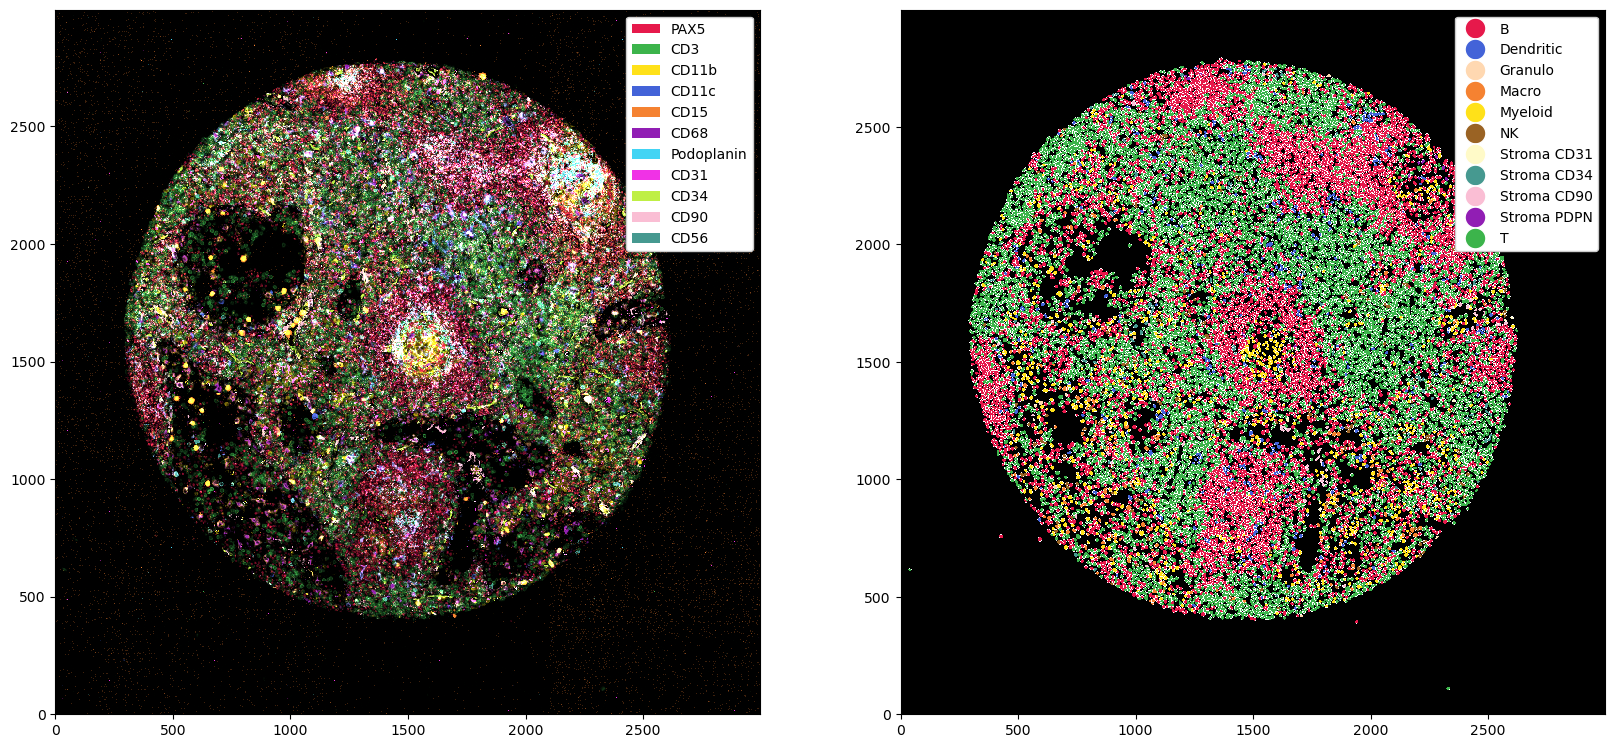

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# downsampling again for RAM reasons
_ = sp_object_thresholded.pp.downsample(4).pl.show(ax=ax[0])
_ = sp_object_thresholded.pl.show(render_image=False, render_segmentation=True, render_labels=True, ax=ax[1])

And this is how easy it can be to perform analysis of highly multiplexed immunofluorescence images! If you have any additional questions, check out the other notebooks for details.